# Homework 5 - Chris Benson
## Weather Predition
March 12, 2018

-------------
### Part 1: Load and parse the airport list
Load the data set of airports into pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import datetime
import collections
from threading import Thread
import time
import json
from pandas.io import sql
import sqlite3

%matplotlib inline

In [2]:
## Load the full data set of US airport information. Use the ICAO code as the index
fullAirportDataSet = pd.read_csv('./ICAO_airports.csv',index_col=1)
## Load the csv of the top 50 airports. Use the ICAO code as the index
top50AirportDataSet = pd.read_csv('./top_airports.csv',index_col=3)

In [3]:
### create a database to dump these results to
connection = sqlite3.connect("./airportData.sql")
cursor = connection.cursor()

## dump airport info and top 50 airports to an sql database
fullAirportDataSet.to_sql('airportData',connection,if_exists='replace')
top50AirportDataSet.to_sql('topFiftyAirports',connection,if_exists='replace')
connection.close()


In [4]:
# Test reading the airport information tables we created.
connection = sqlite3.connect("./airportData.sql")
cursor = connection.cursor()

testAirportExtraction = pd.read_sql_query("select * from airportData;", connection)
testTop50Airports = pd.read_sql_query("select * from topFiftyAirports;", connection)

connection.close()

## Weather scrapeing functions and execution

`ScrapeAirportWeatherData` scrapes weather data for an airport (airportCode) over the course of 1 calendar year (inputYear).

`scrapeSeveralYearsOfWeatherData` scrapes and concatenates weather data over several calendar years.

Loops defined after the functions execute the scraping and write to file. 
The second loop can load previously scraped data from disk so that we don't have to scrape again if we restart the program

In [5]:
# construct the webscraper
# the URL will be of the form: 
# https://www.wunderground.com/history/airport/KGEG/2015/3/12/CustomHistory.html?dayend=11&monthend=3&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

def ScrapeAirportWeatherData(airportCode,inputYear):
    '''
    Function will scrape 1 year of historical weather data from www.wunderground.com at airports.
    I've had trouble getting more than 1 year at a time reliably. Recommend scraping no more than 1 year at a time.
    
    Input: string airport code (string), startData (datetime object), endDate (datetime object)
    Output: pandas data frame with historical weather information
    '''
    startDate = datetime.date(inputYear,1,1)
    endDate = datetime.date(inputYear,12,31)
    
    tempURL = 'https://www.wunderground.com/history/airport/'+str(airportCode)+'/'+str(startDate.year)+'/'+str(startDate.month)+'/'+str(startDate.day)+'/CustomHistory.html?dayend='
    tempURL += str(endDate.day)+'&monthend='+str(endDate.month)+'&yearend='+str(endDate.year)+'&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo='
    page = requests.get(tempURL)
    soup = BeautifulSoup(page.text, 'lxml')
    table = (soup.find_all('table'))[1] # we know that the second table on this page contains the data we want to scrape
    
    # Get the table
    table = (soup.find_all('table'))[1]
    # pull out the table headers
    tableHeaders = table.find_all('th')[1:9]

    subCategories = ['high','avg','low']
    dataDict = collections.OrderedDict()
    # dataDict['Date'] = []
    dateVect = []
    for aHeader in tableHeaders:
        if aHeader.text == 'Precip. (in)':
            dataDict[aHeader.text+' sum'] = []
            continue
        elif aHeader.text == 'Events':
            dataDict[aHeader.text] = []
            continue
        for aSub in subCategories:
            dataDict[aHeader.text+' '+aSub] = []

    ### grab all of the data in the table
    data = table.find_all('tbody')
    dictKeys = list(dataDict.keys())
    # Loop over all of the 'rows' in the table
    for aRow in data:
        # determine if we should skip the row by checking if it has an href in the first element or not
        if aRow.find_all('td')[0].find('a') == None: # skip condition
            continue
        cols = aRow.find_all('td')
        for index,aCol in enumerate(cols):
            # get the date of this data row from the href element 
            dictIndex = index-1
            if index == 0:
                dateStr = aCol.find('a').attrs['href'].split('/')[4:7]
                tempDate = datetime.date(int(dateStr[0]),int(dateStr[1]),int(dateStr[2]))
                dateVect.append(tempDate)
            else:
                # we know that these rows have lots of strings, so exculde them from trying to add as a float
                if dictKeys[dictIndex] not in ['Precip. (in) sum','Events']: 
                    tempVal = aCol.text
                    tempVal = tempVal.replace('\n','')
                    tempVal = tempVal.replace(' ','')
                    if tempVal == '-': # if it is a '-', append as an nan
                        tempVal = np.nan
                    dataDict[dictKeys[dictIndex]].append(float(tempVal)) # cast as float and add to the dict data
                else:
                    tempVal = aCol.text
                    tempVal = tempVal.replace('\n','')
                    dataDict[dictKeys[dictIndex]].append(tempVal)
    DataOut = pd.DataFrame(dataDict,index=dateVect) # dump the data to a pandas data frame and return
    return DataOut

def scrapeSeveralYearsOfWeatherData(airportCode,startYear,endYear,writeToDisk=True,databaseConnection=None):
    '''
    Scrapes the weather data over several years using multiple calls of ScrapeAirportWeatherData. 
    Will scrape and concatenate the DataFrames for the entire calander years from startYear to endYear.
    If writeToDisk == True, write scraped results to file so that the results can be loaded later.
    '''
    # pull down all of the weather data over year range
    dataObjs = []
    for aYear in range(startYear,endYear+1):
        dataObjs.append(ScrapeAirportWeatherData(airportCode,aYear))
    # merge the data together into a single data frame
    masterDF = pd.concat(dataObjs)
    if writeToDisk:
        masterDF.to_sql(str(airportCode),connection,if_exists='replace') # set the table name as the airport code
#         masterDF.to_csv('./histData/'+airportCode+'.csv')
    return masterDF


In [ ]:
### scrape the data for each airport in the top 50 and store in database
connection = sqlite3.connect("./weatherData.sql")
cursor = connection.cursor()

totalSet = []
for aName in list(top50AirportDataSet.index.values):
    print(aName)
    histDataSet = scrapeSeveralYearsOfWeatherData(aName,2008,2018,True)
    totalSet.append({'name':aName,'data':histDataSet})

connection.close() # close database connection

In [18]:
### An alternative load method to read previously scraped data from disk (b/c it takes a while to scrape all of the data)
connection = sqlite3.connect("./weatherData.sql")
cursor = connection.cursor()

totalSet = []
date_parser = pd.core.tools.datetimes.to_datetime
for aName in list(top50AirportDataSet.index.values):
#     histDataSet = pd.read_csv('./histData/'+str(aName)+'.csv',index_col=0) # csv dump/load option
    histDataSet = pd.read_sql_query("select * from "+str(aName)+";", connection,index_col='index') # load the result into memory
    histDataSet.index = pd.to_datetime(histDataSet.index)
    totalSet.append({'name':aName,'data':histDataSet})
    
connection.close()


## Evaluate correlations
Now that the data has been scraped (or loaded from disk), compute the correlations between various offsets in time for temperature and humidity.

Also save these results to file so we don't have to rerun them each time we restart this file (as it took a long time).

In [19]:
def computeCoorelation(x,y,timeDelta=3):
    '''
    x is a pandas Series,
    y is a pandas Series which is offset in time by the amount specified by timeDelta in days
    
    Exclude times when a nan is present in either x or y 
    
    returns the correlation matrix between x and y
    '''
    index = []
    xVals = []
    yVals = []
    for anIndex in x.index[:(-1*timeDelta-1)]:
        xIndex = anIndex
        yIndex = anIndex + datetime.timedelta(timeDelta)
        try:
            if np.isnan(x.loc[xIndex]) or np.isnan(y.loc[yIndex]):
                continue
        except:
            continue
        index.append(anIndex)
        xVals.append(x.loc[xIndex])
        yVals.append(y.loc[yIndex])
    # evaluate the correlation
    result = np.corrcoef(xVals,yVals)
    return result
        

In [ ]:
# Loop to compute the temperature and humidity correlation values for 1, 3, and 7 day offset periods for the various combinations of airports
orderedAirportNames = list(top50AirportDataSet.index.values)
temperatureCoor1Day = []
temperatureCoor3Day = []
temperatureCoor7Day = []
humidityCoor1Day = []
humidityCoor3Day = []
humidityCoor7Day = []
orderedPairs = []
for index1,name1 in enumerate(orderedAirportNames):
    if index1 == len(orderedAirportNames)-1:
        break
    for index2,name2 in enumerate(orderedAirportNames[index1+1:]):
        xTemp = totalSet[index1]['data']['Temp. (°F) high']
        yTemp = totalSet[index1+index2+1]['data']['Temp. (°F) high']
        orderedPairs.append([orderedAirportNames[index1],orderedAirportNames[index1+index2+1]])
        print(orderedPairs[-1])
        temperatureCoor1Day.append(computeCoorelation(xTemp,yTemp,timeDelta=1)[0][1])
        temperatureCoor3Day.append(computeCoorelation(xTemp,yTemp,timeDelta=3)[0][1])
        temperatureCoor7Day.append(computeCoorelation(xTemp,yTemp,timeDelta=7)[0][1])
        
        xHum = totalSet[index1]['data']['Humidity (%) high']
        yHum = totalSet[index1+index2+1]['data']['Humidity (%) high']
        humidityCoor1Day.append(computeCoorelation(xHum,yHum,timeDelta=1)[0][1])
        humidityCoor3Day.append(computeCoorelation(xHum,yHum,timeDelta=3)[0][1])
        humidityCoor7Day.append(computeCoorelation(xHum,yHum,timeDelta=7)[0][1])
        
# write the coorelation results to a json file so we dont have to re-run them again (it took a long time).
dictOut = {"temperatureCoor1Day":temperatureCoor1Day,"temperatureCoor3Day":temperatureCoor3Day,
           "temperatureCoor7Day":temperatureCoor7Day,"humidityCoor1Day":humidityCoor1Day,
          "humidityCoor3Day":humidityCoor3Day,"humidityCoor7Day":humidityCoor7Day,"orderedPairs":orderedPairs}
dictFileOut = open('./coorResults.json','w+')
json.dump(dictOut,dictFileOut)
dictFileOut.close()

In [20]:
# load the correlation data from file (so we don't have to run above code everytime)
dictOut = json.load(open('./coorResults.json','r'))

## Compute the distance between the various pairs of airports

Use geopy to compute the distance between pairs of coordinates

In [21]:
# now compute the distance between all of the pairs we evaluated coorlations for using geopy
from geopy.distance import great_circle
pairDistance = []
longitudeDelta = []
for aPair in dictOut['orderedPairs']:
    coord1 = (fullAirportDataSet.loc[aPair[0]]['latitude_deg'],fullAirportDataSet.loc[aPair[0]]['longitude_deg'])
    coord2 = (fullAirportDataSet.loc[aPair[1]]['latitude_deg'],fullAirportDataSet.loc[aPair[1]]['longitude_deg'])
    tempDistance = great_circle(coord1, coord2).miles
    pairDistance.append(tempDistance)
    longitudeDelta.append(fullAirportDataSet.loc[aPair[1]]['longitude_deg']-fullAirportDataSet.loc[aPair[0]]['longitude_deg'])

In [22]:
def returnSortedIndex(arrayToSort):
    return sorted(range(len(arrayToSort)), key=lambda k: arrayToSort[k])

def getPlottableVectors(sortedIndexVect,coorVect,distVect,pairVect,longitudeDeltaVect):
    sortedIndex = sortedIndexVect[::-1]
    coorOut = []
    distOut =[]
    pairOut = []
    longDelta = []
    for aVal in sortedIndex:
        coorOut.append(coorVect[aVal])
        distOut.append(distVect[aVal])
        pairOut.append(pairVect[aVal])
        longDelta.append(longitudeDeltaVect[aVal])
    return coorOut,distOut,pairOut,longDelta

### sort each of the data set's indicies by increasing coorelation value
sortedTemp1Day = getPlottableVectors(returnSortedIndex(dictOut['temperatureCoor1Day']),dictOut['temperatureCoor1Day'],pairDistance,dictOut['orderedPairs'],longitudeDelta)
sortedTemp3Day = getPlottableVectors(returnSortedIndex(dictOut['temperatureCoor3Day']),dictOut['temperatureCoor3Day'],pairDistance,dictOut['orderedPairs'],longitudeDelta)
sortedTemp7Day = getPlottableVectors(returnSortedIndex(dictOut['temperatureCoor7Day']),dictOut['temperatureCoor7Day'],pairDistance,dictOut['orderedPairs'],longitudeDelta)
sortedHumidity1Day = getPlottableVectors(returnSortedIndex(dictOut['humidityCoor1Day']),dictOut['humidityCoor1Day'],pairDistance,dictOut['orderedPairs'],longitudeDelta)
sortedHumidity3Day = getPlottableVectors(returnSortedIndex(dictOut['humidityCoor3Day']),dictOut['humidityCoor3Day'],pairDistance,dictOut['orderedPairs'],longitudeDelta)
sortedHumidity7Day = getPlottableVectors(returnSortedIndex(dictOut['humidityCoor7Day']),dictOut['humidityCoor7Day'],pairDistance,dictOut['orderedPairs'],longitudeDelta)


## Correlation strength vs distance for temperature

This plot shows the correlation strength as a function of distance for high temperature for time offsets of 1, 3, and 7 days. It makes sense that The correlation strength is large for airports that are relatively close to eachother and for time close together. For longer time periods, we see weakening corrleations, but with larger distance. This makes sense because as weather fronts move (i.e. hot or cold fronts), the temperature of locations farther away will be correlated in temperature. To first order, this provides a measure of the average speed of fronts (correlation distance as a function of elapsed time).

Text(0,0.5,'Correlation strength')

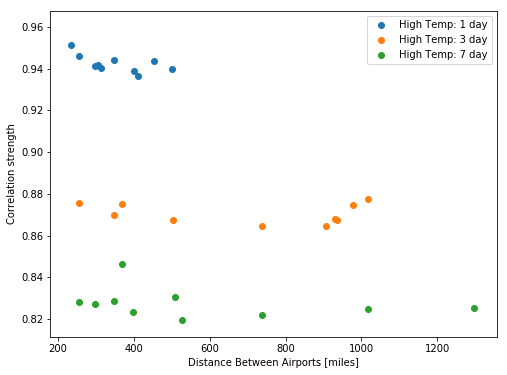

In [23]:
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(sortedTemp1Day[1][:10],sortedTemp1Day[0][:10],label='High Temp: 1 day')
ax.scatter(sortedTemp3Day[1][:10],sortedTemp3Day[0][:10],label='High Temp: 3 day')
ax.scatter(sortedTemp7Day[1][:10],sortedTemp7Day[0][:10],label='High Temp: 7 day')
ax.legend(loc=1)
ax.set_xlabel('Distance Between Airports [miles]')
ax.set_ylabel('Correlation strength')

## Correlation strength vs distance for humidity

This plot is similar to the one above. There is decreasing correlation with elapsed time and distance. The inturrpretation of this plot is consistent with the speed of moving fronts previously discussed. I expect the overall correlation to be weaker than the temperature because humidity may coorespond to rain storms. This is because rain is less predicatable than temperature. For example, when a cold/warm front moves through, one is very certian that all areas locally will expereince a temperature change. For a rainstorm front, it is not totally certian that everywhere will recieve rain, thus a weaker corrleation.

Text(0,0.5,'Correlation strength')

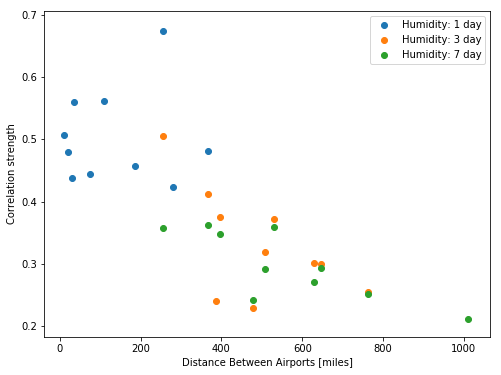

In [24]:
fig2,ax2 = plt.subplots(figsize=(8,6))
ax2.scatter(sortedHumidity1Day[1][:10],sortedHumidity1Day[0][:10],label='Humidity: 1 day')
ax2.scatter(sortedHumidity3Day[1][:10],sortedHumidity3Day[0][:10],label='Humidity: 3 day')
ax2.scatter(sortedHumidity7Day[1][:10],sortedHumidity7Day[0][:10],label='Humidity: 7 day')
ax2.legend(loc=1)
ax2.set_xlabel('Distance Between Airports [miles]')
ax2.set_ylabel('Correlation strength')

## Correlation strength vs longitudinal Coodinate $\Delta$

The plot shows that there is a bias for weather patterns to move in the west to east direction. This is consistent with usual weather patterns in the US and is driven by the direction that the jet stream is traveling. As expected, there is a strong corrleation for short time offsets and a weakening correlation as time passes.

Text(0,0.5,'Correlation strength')

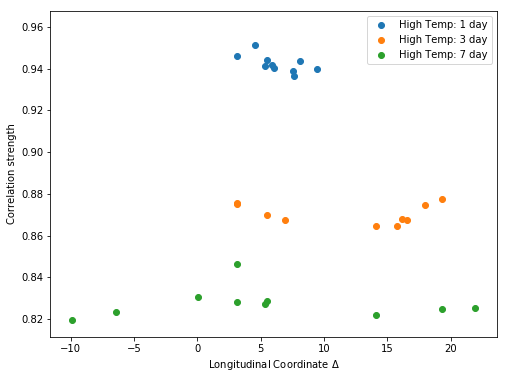

In [25]:
fig3,ax3 = plt.subplots(figsize=(8,6))
ax3.scatter(sortedTemp1Day[3][:10],sortedTemp1Day[0][:10],label='High Temp: 1 day')
ax3.scatter(sortedTemp3Day[3][:10],sortedTemp3Day[0][:10],label='High Temp: 3 day')
ax3.scatter(sortedTemp7Day[3][:10],sortedTemp7Day[0][:10],label='High Temp: 7 day')
ax3.legend(loc=1)
ax3.set_xlabel('Longitudinal Coordinate $\Delta$')
ax3.set_ylabel('Correlation strength')

## Correlation strength vs longitudinal Coodinate $\Delta$, Humidity

The correlation with humidity is quite different that with high temperature (previous plot). The correlations are weaker so it is difficult to come up with a strong argument.

Text(0,0.5,'Correlation strength')

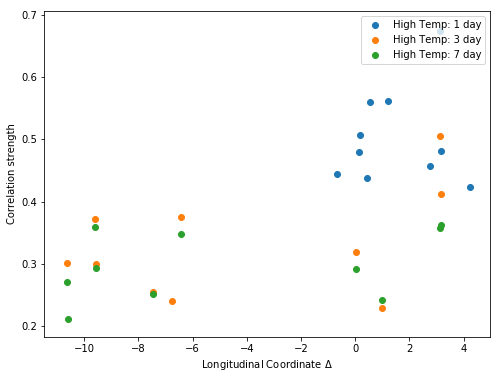

In [26]:
fig4,ax4 = plt.subplots(figsize=(8,6))
ax4.scatter(sortedHumidity1Day[3][:10],sortedHumidity1Day[0][:10],label='High Temp: 1 day')
ax4.scatter(sortedHumidity3Day[3][:10],sortedHumidity3Day[0][:10],label='High Temp: 3 day')
ax4.scatter(sortedHumidity7Day[3][:10],sortedHumidity7Day[0][:10],label='High Temp: 7 day')
ax4.legend(loc=1)
ax4.set_xlabel('Longitudinal Coordinate $\Delta$')
ax4.set_ylabel('Correlation strength')